In [2]:
import pandas as pd
import sklearn
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, PowerTransformer, StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#load the data from the csv to the pandas df


In [38]:
def data_transformer(df):
    columns_to_drop = ["imdb_id", "original_title", "poster_path", "status", "title"]
    df.drop(columns=columns_to_drop, inplace=True)
    df["belongs_to_collection"] = np.where(df["belongs_to_collection"].isnull(), 0, 1)
    df["homepage"] = np.where(df["homepage"].isnull(), 0, 1)
    df["original_language"] = np.where(df["original_language"]=="en", 1, 0)
    df['release_date'] = pd.to_datetime(df['release_date'], format='%m/%d/%y')
    df['release_year'] = df['release_date'].dt.year
    df['budget_year_ratio'] = df['budget']/df['release_year']
    df['release_date'] = df['release_date'].apply(lambda x: x.replace(year=x.year-100) if x.year > 2019 else x)
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['overview'] = df['overview'].astype(str).apply(len)
    df['tagline'] = df['tagline'].astype(str).apply(len)
    
    colList = ["production_companies", "genres", "spoken_languages",  "cast", "crew", "production_countries"]
    for col in colList:
        df[col] = np.where(df[col].isnull(), "[]", df[col])
        df[col] = df[col].apply(ast.literal_eval)
        df[col] = df[col].apply(lambda x: [str(item["name"]) for item in x])
        mlb = MultiLabelBinarizer()
        newData = mlb.fit_transform(df[col])
        newDf = pd.DataFrame(newData, columns=col+"_" + mlb.classes_)
        df = pd.merge(df, newDf, how='inner', left_index=True, right_index=True)
        df[col] = df[col].apply(len)
        df = df.rename(columns={col: col+"_num"})
    if 'genres_10770' not in df.columns:
        df['genres_10770'] = 0

    colList = ["Keywords",]

    for col in colList:
        df[col] = np.where(df[col].isnull(), "[]", df[col])
        df[col] = df[col].apply(ast.literal_eval)
        df[col] = df[col].apply(len)
        df = df.rename(columns={col: col+"_num"})
    return df

In [39]:
train = pd.read_csv('train.csv')

test = pd.read_csv('test.csv')

all_data = data_transformer(pd.concat([train, test]).reset_index(drop = True))
training = all_data.loc[:train.shape[0] - 1,:]
testing = all_data.loc[train.shape[0]:,:] 


In [40]:
logTransformList = ['budget', 'budget_year_ratio']

for col in logTransformList:
    training[col] = np.log1p(training[col])

columns_to_standardize = ['budget', 'genres_num','popularity', 'production_companies_num','production_countries_num', 'runtime',
       'spoken_languages_num', 'Keywords_num', 'cast_num', 'crew_num','overview', 'tagline']
dropCol = ['id', 'revenue', 'release_date']
xScaler = StandardScaler()
normalCol = [x for x in training.columns if x not in columns_to_standardize]
normalCol = [x for x in normalCol if x not in dropCol]
# normalCol = ['belongs_to_collection',  'homepage',
#        'original_language', 
#         'genres_10402', 'genres_10749', 'genres_10751',
#        'genres_10752', 'genres_10769', 'genres_10770', 'genres_12',
#        'genres_14', 'genres_16', 'genres_18', 'genres_27', 'genres_28',
#        'genres_35', 'genres_36', 'genres_37', 'genres_53', 'genres_80',
#        'genres_878', 'genres_9648', 'genres_99']
standardized = xScaler.fit_transform(training[columns_to_standardize])

# Concatenate the standardized columns with the original columns
X_train = np.concatenate((standardized, training[normalCol]), axis=1)

training['revenue'] = np.log1p(training['revenue'])
y_train = training['revenue']
y_train = y_train.values.reshape(-1, 1)

yScaler = StandardScaler()
y_train = yScaler.fit_transform(y_train)
y_train = y_train.ravel()
for col in logTransformList:
    testing[col] = np.log1p(testing[col])
standardized = xScaler.transform(testing[columns_to_standardize])

# Concatenate the standardized columns with the original columns
X_test = np.concatenate((standardized, testing[normalCol]), axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_46760\2158897774.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training[col] = np.log1p(training[col])
C:\Users\user\AppData\Local\Temp\ipykernel_46760\2158897774.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['revenue'] = np.log1p(training['revenue'])
C:\Users\user\AppData\Local\Temp\ipykernel_46760\2158897774.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [35]:
X_train.shape

(3000, 163924)

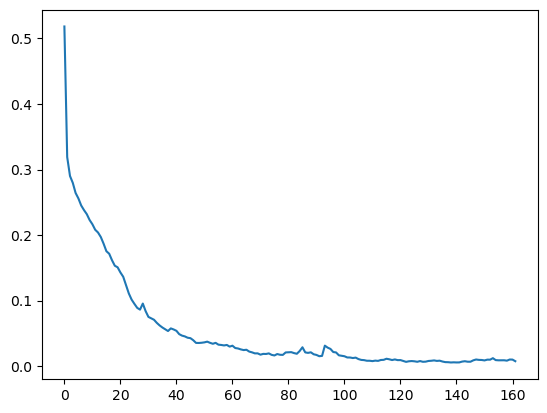

In [19]:
model = MLPRegressor(hidden_layer_sizes=(1024, 64), batch_size=512, learning_rate_init=0.004, max_iter=1000, learning_rate="invscaling", early_stopping=True, n_iter_no_change=100, solver="adam")
model.fit(X_train, y_train)
plt.plot(model.loss_curve_)
y_test = model.predict(X_test)
yResult = np.expm1(yScaler.inverse_transform(y_test.reshape(-1, 1)).flatten())
submitResult = pd.DataFrame({'id': testing['id'], 'revenue': yResult})
submitResult.to_csv('submit.csv', index=False)

In [47]:
submitResult = pd.DataFrame({'id': testing['id'], 'revenue': yResult})
submitResult.to_csv('submit.csv', index=False)

In [47]:
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE

train_X, test_X, train_y, test_y = train_test_split(X_train, y_train, 
                      test_size = 0.3, random_state = 123)
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 15, seed = 123, max_depth=6) 
xgb_r.fit(train_X, train_y) 
  
# Predict the model 
pred = xgb_r.predict(test_X) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(test_y, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.663468


In [46]:
y_test = xgb_r.predict(X_test)
yResult = np.expm1(yScaler.inverse_transform(y_test.reshape(-1, 1)).flatten())
submitResult = pd.DataFrame({'id': testing['id'], 'revenue': yResult})
submitResult.to_csv('submit.csv', index=False)